# Linear Regression in PyTorch


In this tutorial, you will be given the basic tools needed to make use of PyTorch during the **[Machine Perception](https://ait.ethz.ch/teaching/courses/2021-SS-Machine-Perception/)** course.
We will be using PyTorch's [Python 3 API](https://pytorch.org/docs/stable/index.html) during the class, exercises and projects. 
This tutorial consists of:

1. Installing PyTorch (Local)
2. AutoGrad
3. Tensors
4. Training
5. Tensorboard

## 1. Installing PyTorch

PyTorch is a library for machine learning primarily developed by Facebook. The latest 1.x release as of today is [version 1.10.2](https://github.com/pytorch/pytorch/releases).
PyTorch offers [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) and GPU acceleration via CUDA and cuDNN.
Automatic differentiation allows for flexible specifications of data flow and gradient-based optimization, and Nvidia's [cuDNN library](https://developer.nvidia.com/cudnn) provides much needed acceleration for common deep learning methods and routines.
Of course, PyTorch benefits from Facebook's quick development cycles.
This can be a bane sometimes as differences between major versions can break compatibility for written code as well as stored model variables.

---

For your project, you will be using [Euler cluster] where PyTorch and CUDA will already be setup for you.

For tutorials, we will be using [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb).

Hence, the following instructions are provided only in case you need them.

---

To install PyTorch, follow [this guide](https://pytorch.org/get-started/locally/) and use the Python package manager **pip**. To enable GPU support you will have to install the appropriate versions of CUDA and cuDNN. To do so:

*   Follow the [official installation guide from PyTorch](https://pytorch.org/get-started/locally/).
*   If that does not work, follow the official NVIDIA installation guide for [CUDA](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html) and [cuDNN](https://docs.nvidia.com/deeplearning/sdk/cudnn-install/index.html#installcuda).

If everything works, you should be able to:
*   See your GPU when issuing `nvidia-smi` on the console.
*   Import PyTorch in a python console (`import torch`) and create a random tensor (`torch.rand(5, 3)`).

As a side note, in order to find out the version numbers of Python 3, CUDA, and other libraries on a Debian/Ubuntu system, you can run some of the following commands:

    # Version of installed PyTorch
    pip3 show torch
    
    # Python 3
    python3 --version
    
    # CUDA/cuDNN versions
    dpkg -l | grep '^.i.*cuda-'
    dpkg -l | grep '^.i.*libcudnn-'

Once all is ready, the following should succeed:

In [ ]:
!python3 --version

Python 3.8.10


In [ ]:
import torch

For this tutorial, we will import a few more libraries:

In [ ]:
# Uncomment below to directly install packages from a Jupyter notebook
#!pip3 install numpy imageio matplotlib sklearn

import torchvision               # For processing image within the PyTorch framework
import glob                      # For scanning a folder for files
import imageio                   # For reading images
%matplotlib inline
import matplotlib.pyplot as plt  # For plotting graphs
import numpy as np               # Numpy for handling matrices
import os                        # For manipulating file paths
import queue                     # For queueing of input data (during preprocessing)
import skimage                   # For image processing
import sklearn.datasets          # For regression data
import scipy.stats               # For linear-fit before plot
import threading                 # For multi-threading
import urllib                    # For downloading data
import warnings
import skimage.transform

warnings.filterwarnings('ignore')

## 2. Dynamic graphs & AutoGrad



This section is inspired by [A Gentle Introduction to torch.autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).


----

### 1) Dynamic graphs 

An optimizable mathematical model such as linear regression and neural networks are formed of a sequence of mathematical operations, often depicted in the form of a graph.

PyTorch represents chains of mathematical or algorithmic operations as a computational graph. 

In this graph, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

**Graphs are dynamic in PyTorch** : An important thing to note is that after each .backward() call, the graph is recreated from scratch and PyTorch starts populating a new graph. This is exactly what allows you to use control flow statements in your model: you can change the shape, size and operations at every iteration if needed.

This contrasts with [TensorFlow v1](https://https://www.tensorflow.org/versions/r1.15/api_docs/python/tf) where graphs are static. You have to define the entire computational graph, compile it and then run your model with data.

----

### 2) AutoGrad

The computational engine that populates the graph and uses it to compute the gradients is called `TORCH.AUTOGRAD`.

Conceptually, autograd keeps a record of data (tensors) & all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. 

In a **forward pass**, autograd does two things simultaneously:

*   run the requested operation to compute a resulting tensor
*   maintain the operation’s gradient function in the DAG.


The **backward pass** kicks off when .backward() is called on the DAG root. 
Autograd then:

*   computes the gradients from each .grad_fn,
*   accumulates them in the respective tensor’s .grad attribute
*   using the chain rule, propagates all the way to the leaf tensors.
----

### 3) Short example

Lets have a short demonstration. 

We create two tensors a and b with `requires_grad=True`. This signals to autograd that every operation on them should be tracked.

In [ ]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

We create another tensor Q from a and b : **Q = 3a&sup3; - b&sup2;**

In [ ]:
Q = 3*a**3 - b**2

When we call `.backward()` on Q, autograd calculates these gradients and stores them in the respective tensors’ `.grad` attribute.

We need to explicitly pass a `gradient` argument in `Q.backward()` because it is a vector. `gradient` is a tensor of the same shape as Q, and it represents the gradient of Q w.r.t. itself

In [ ]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient = external_grad)

Gradients are now deposited in `a.grad` and` b.grad`

In [ ]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


## 3. Tensors

So how do we actually pass data to PyTorch ? We convert it to a [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html) using the [`torch.tensor`](https://pytorch.org/docs/stable/generated/torch.tensor.html#torch.tensor) constructor.

Let's see an example.

Downloaded an image and resized it to be size 720x720x3


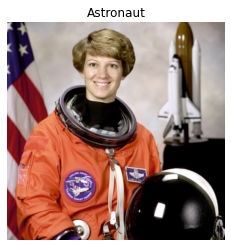

In [ ]:
# Download an image
ast = skimage.data.astronaut()
# Astronaut image shape is (720, 720, 3)
ast = skimage.transform.resize(ast, (720, 720))
h, w, c = ast.shape
print('Downloaded an image and resized it to be size %dx%dx%d' % (h, w, c))

plt.imshow(ast); plt.grid(False); plt.axis('off'); plt.title('Astronaut'); 

Lets try out some built-in image processing functions.

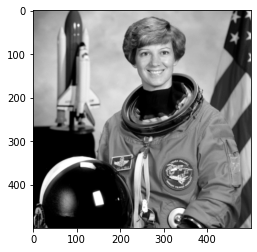

In [ ]:
# Define input tensor
input_image = torch.tensor(ast, requires_grad=False)

# Switch first and last dimensions as torchvision operations expect
# input tensor in the format (channels, height, width)
input_image = input_image.transpose(2, 0)

# Define a few operations
scaled_image = torchvision.transforms.functional.resize(input_image, size=(500, 500)) # resize image
flipped_image = torchvision.transforms.functional.vflip(scaled_image) # vertical flip
grayscale_image = torchvision.transforms.functional.rgb_to_grayscale(flipped_image) # convert to grayscale

# Convert back torch.Tensor to numpy array in order to display it
grayscale_image_numpy = grayscale_image.numpy()

# matplotlib.pyplot.imshow expects input of size (height, width, channels)
output_image = grayscale_image_numpy.transpose((2, 1, 0))

plt.imshow(output_image.reshape(500, 500), cmap='gray'); plt.show()

## 4. Training

Now we can put our knowledge together to train a simple linear regression model which can predict house prices in the Boston area during the 70s. See [this page](https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-dataset) for more information.

This dataset consists of:
- 13 features
- 1 label
- 506 entries

Let's get the dataset first.

In [ ]:
# Set seed to make result reproducible
np.random.seed(12345)

# Grab dataset
xs, ys = sklearn.datasets.fetch_california_housing(return_X_y=True)
ys = ys.reshape(-1, 1)  # Make ys 2-dimensional (was vector)

# Record some known dimensions
num_entries, num_features = xs.shape
_, num_labels= ys.shape

# xs has num_entries rows and the following columns.
# MedInc:     median income in block group
# HouseAge:   median house age in block group
# AveRooms:   average number of rooms per household
# AveBedrms:  average number of bedrooms per household
# Population: block group population
# AveOccup:   average number of household members
# Latitude:   block group latitude
# Longitude:  block group longitude

# ys consists of the following:
#
# MEDV    Median value of owner-occupied homes in $100,000’s

We can now split the dataset into training data and test data.

Note that in practice, you should further create a validation set on which you tune hyperparameters.

In [ ]:
# Split given data
num_test_entries = 64
num_training_entries = num_entries - num_test_entries

# We should like to shuffle the data before making splits.
# Achieve this by creating permutations of available indices.
all_indices_randomized = np.random.permutation(num_entries)

# Select training indices
training_indices = all_indices_randomized[:num_training_entries]
training_indices = sorted(training_indices)
training_data = (xs[training_indices, :], ys[training_indices, :])

# Select test indices
test_indices = all_indices_randomized[-num_test_entries:]
test_indices = sorted(test_indices)
test_data = (xs[test_indices, :], ys[test_indices, :])

print('Training data has %d entries.' % num_training_entries)
print('Test data has %d entries.' % num_test_entries)

Training data has 20576 entries.
Test data has 64 entries.


---

You can use any of the following libraries for reading input data:

- [`imageio.imread`](https://imageio.readthedocs.io/en/latest/userapi.html) for images.
- [`scipy.io.loadmat`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html) for Matlab `.mat` files. Make sure to use the `squeeze_me` argument!
- [`h5py.File`](http://docs.h5py.org/en/latest/high/file.html) for HDF5.
- [`numpy.loadtxt`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html) for `csv` files or other text-based data.
- Python's [`pickle`](https://docs.python.org/3/library/pickle.html) is a popular format as well, but beware of compatibility between Python versions.

and last but not least, [`pandas`](https://pandas.pydata.org/pandas-docs/stable/reference/io.html) is a good option for general data reading.

---

Once we have read and split our data, we convert it to `torch.Tensors` and create [`torch.utils.data.TensorDatasets`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for both training and testing datasets.

We can select the device (CPU or GPU) we want to use and explictly pass it to the `torch.Tensor` constructor.

In [ ]:
# use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is {device}.")

# create torch.Tensors for training xs and ys
training_xs = torch.tensor(training_data[0], device=device).float()
training_ys = torch.tensor(training_data[1], device=device).float()
# create torch.Tensors for test xs and ys
test_xs = torch.tensor(test_data[0], device=device).float()
test_ys = torch.tensor(test_data[1], device=device).float()

# create datasets 
training_set = torch.utils.data.TensorDataset(training_xs, training_ys)
test_set = torch.utils.data.TensorDataset(test_xs, test_ys)

Device is cpu.


We now batch our dataset and obtain an iterable over it via [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). 

In [ ]:
batch_size = 64

# create dataloader for training and test datasets 
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

We can now define a very simple neural network.
In this example, we use [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).
While it is possible to manually define weights and biases, this is no longer necessary with PyTorch and can make your code unnecessarily complex.

In [ ]:
# define linear regression model
# note : if GPU is available you must add .to(device) to your model to moves its weights to the GPU
model = torch.nn.Linear(in_features=num_features, out_features=num_labels, bias=True).to(device)

By defining an optimizer, we can express how the constructed computational graph should be optimized. This involves:

1. Selecting an [optimization method](https://pytorch.org/docs/stable/optim.html) such as stochastic gradient descent (Adam is popular).
2. Setting learning rate and other optimizer specific parameters.
3. Defining a loss or cost function.
4. Selecting variables which can be optimized.

To optimize only selected variables, one can:
1. Setting the `requires_grad` argument to False if the tensor shouldn't be updated.
2. Passing only the variables that should be trained to the optimizer.
3. Use the context manager `torch.no_grad()`



In our example below, we optimize all optimizeable variables by passing `model.parameters()` to the optimizer `torch.optim.Adam`.

In [ ]:
# Define a mean-squared-error loss function
loss_function = torch.nn.MSELoss()

# Define optimizer
learning_rate = 0.0025
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

The model, loss and optimizer are now defined. We can train it.

In [ ]:
# Set seed to make result reproducible
torch.manual_seed(0)

# Select the number of full dataset passes or epochs
n_epochs = 725

# Put model in training mode 
# Note : this is important as not all layers have the same behavior at 
# training and testing time (ex. Dropout, Batchnorm)
model.train()

step = 0
for epoch in range(n_epochs):
    for i, (input, target) in enumerate(training_loader):
        optimizer.zero_grad()   # zero the gradient buffers
        output = model(input)   # forward pass
        loss = loss_function(output, target)    # compute loss
        loss.backward() # backward pass
        optimizer.step()    # does the update
        if step % 1000 == 0:
            print('[Epoch %04d] - Step %04d> training loss: %.2f' % (epoch, step, loss.item())) 
        step += 1

[Epoch 0000] - Step 0000> training loss: 317517.41
[Epoch 0003] - Step 1000> training loss: 117.37
[Epoch 0006] - Step 2000> training loss: 4.53
[Epoch 0009] - Step 3000> training loss: 2.52
[Epoch 0012] - Step 4000> training loss: 0.96
[Epoch 0015] - Step 5000> training loss: 1.07
[Epoch 0018] - Step 6000> training loss: 0.88
[Epoch 0021] - Step 7000> training loss: 0.64
[Epoch 0024] - Step 8000> training loss: 0.62
[Epoch 0027] - Step 9000> training loss: 0.66
[Epoch 0031] - Step 10000> training loss: 0.38
[Epoch 0034] - Step 11000> training loss: 0.99
[Epoch 0037] - Step 12000> training loss: 0.42
[Epoch 0040] - Step 13000> training loss: 6.80
[Epoch 0043] - Step 14000> training loss: 0.54
[Epoch 0046] - Step 15000> training loss: 0.50
[Epoch 0049] - Step 16000> training loss: 0.73
[Epoch 0052] - Step 17000> training loss: 0.73
[Epoch 0055] - Step 18000> training loss: 1.26
[Epoch 0059] - Step 19000> training loss: 0.79
[Epoch 0062] - Step 20000> training loss: 0.71
[Epoch 0065] - S

Now that we have trained a model, let's test its performance.

In [ ]:
# Put the model in evaluation mode
model.eval()

test_losses = []
for input, target in test_loader:
    with torch.no_grad(): # disable gradient computation
        output = model(input)
        loss = loss_function(output, target)
        test_losses += [loss.item()]

print('Mean test loss = %.2f' % np.mean(test_losses))

Mean test loss = 0.82


Now let's quickly make a plot of *house value* vs *number of rooms*...

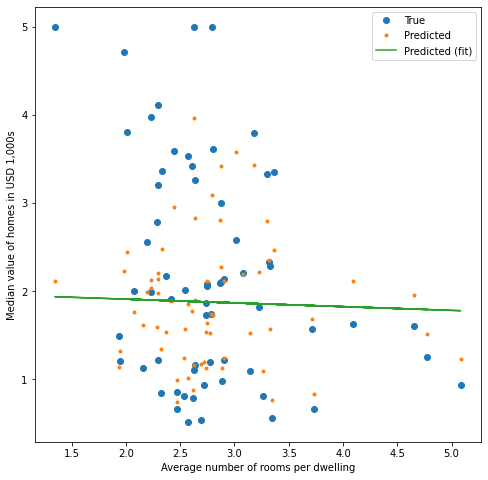

In [ ]:
# Gather data to plot
x = test_data[0][:, 5]  # average number of rooms per dwelling
y_true = test_data[1]

# Note that we don't feed labels as output_tensor doesn't require them.
input_tensor = torch.tensor(test_data[0], device=device).float()
y_predicted_tensor = model(input_tensor)

# Must put back y_predicted_tensor to CPU before converting it to numpy array
y_predicted = y_predicted_tensor.detach().to('cpu').numpy().flatten()

# Plot ground-truth and predictions
plt.figure(figsize=(8, 8))
plt.plot(x, y_true, 'o', label='True')
plt.plot(x, y_predicted, '.', label='Predicted')

# Plot linear-fit for y_predicted
slope, intercept, _, _, _ = scipy.stats.linregress(x, y_predicted)
plt.plot(x, slope * np.array(x) + intercept, label='Predicted (fit)')

# Graph formatting
plt.xlabel('Average number of rooms per dwelling')
plt.ylabel('Median value of homes in USD 1,000s')
plt.legend()
plt.show()

I suppose we could say that houses in the Boston area in the 70s tended to cost more when built to have more rooms.

## 5. Tensorboard and Monitoring Progress

Last but not least, we will briefly touch on the usage of [**Tensorboard**](https://github.com/tensorflow/tensorboard).

Tensorboard allows you to easily monitor your model's progress by providing an intuitive interface displaying metrics over time. In addition, it allows you to:
1. View image outputs
2. View histogram/distribution plots of model parameters
3. Visualize model architecture

and others...

Follow these simple steps to make your experience with tensorboard easier.

---

### Summary operations

Now, we run the same training loop with tensorboard routines. 

In [ ]:
# Clear the logs of previous runs
!rm -rf ./logs/

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
batch_size = 64
learning_rate = 0.0025

# Define linear regression model
model = torch.nn.Linear(in_features=num_features, out_features=num_labels, bias=True).to(device)

# Define a mean-squared-error loss function
loss_function = torch.nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Set seed to make result reproducible
torch.manual_seed(0)

# TensorBoard
train_writer = SummaryWriter(log_dir="./logs/single_layer_model")

# Set number of epochs : number of full data passes 
n_epochs = 725

step = 0
for epoch in range(n_epochs):
    for i, (input, target) in enumerate(training_loader):
        # add histogram of weights to tensorboard
        # we will visualize the distribution of weight and bias values.
        model_parameters = dict(model.named_parameters())
        weight = model_parameters['weight']
        bias = model_parameters['bias']
        train_writer.add_histogram('weight', weight, step) 
        train_writer.add_histogram('bias', bias, step)
        # train
        optimizer.zero_grad()   # zero the gradient buffers
        output = model(input)   # forward pass
        loss = loss_function(output, target)    # compute loss
        loss.backward() # backward pass
        optimizer.step()    # does the update
        # add training loss to summary
        train_writer.add_scalar('training_loss', loss, step)
        if step % 1000 == 0:
            print('[step %04d> training loss: %.2f' % (step, loss.item()))
        step += 1 

        train_writer.add_graph(model, input)
train_writer.flush() # Only calling now (as demo) to ensure content is written to disk.
train_writer.close()

[step 0000> training loss: 20169.31
[step 1000> training loss: 1.66
[step 2000> training loss: 0.73
[step 3000> training loss: 0.69
[step 4000> training loss: 0.49
[step 5000> training loss: 0.62
[step 6000> training loss: 0.53
[step 7000> training loss: 0.61
[step 8000> training loss: 0.59


You will see training loss, distribution of weight & bias parameter values and our graph.

### Monitoring training

The given example works for Tensorboard operating in Colaboratory environment.
This is how you monitor your project experiments.

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./logs/single_layer_model

On a standard machine setup, we can now view our stored logs using Tensorboard for example by calling:

    tensorboard --port 8008 --logdir ./logs

You can learn more about Tensorboard [over here](https://www.tensorflow.org/tensorboard/) with a guide to use Tensorboard with PyTorch [here](https://pytorch.org/docs/stable/tensorboard.html) and another example of things you can do with tensorboard [here](https://https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html).

Note that there are other types of summaries, such as [`image`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_image) and [`histogram`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram) (which are particularly useful for analyzing learned weights and biases.

In general, you will not see data or metrics which you do not explicitly request to be logged. You must therefore:

1. Define a `SummaryWriter`.
2. Evaluate the `SummaryWriter` operations (every $k$ steps during training or testing)
3. And finally, close the `SummaryWriter` once you are finished.

---

# End

This tutorial now ends. If you have any further questions about how PyTorch works, please do the following:

1. Search the web (ie. search [StackOverflow](https://stackoverflow.com/questions/tagged/pytorch)) for solutions to your question.
2. Check our project skeleton code (to be released) to see if there is similar code to what you are attempting.
3. If the question remains unanswered, ask us (and your peers) via [the course Piazza](https://piazza.com/ethz.ch/spring2021/263371000l/home).
4. If you still have difficulty getting help or feedback, you may contact TAs directly.

---

## Questions and Additional Exercises
PyTorch library has plug&play like API, enabling designing sophisticated models. You can copy the cell with tensorboard example and modify the model. You can compare different models in Tensorboard by passing unique names to the `log_dir` :
```
train_writer = SummaryWriter(log_dir="./logs/single_layer_model")
```

<ol>
    <li><b>Increasing Model Capacity</b></li>
    In this toy example we only used one layer. You can try reducing the loss further by stacking more dense layers. Please note that your model can easily overfit and give worse performance. 
  
  <li><b>Learning Rate</b></li>
  You may experiment with very large and very small learning rates. 
  
  <li><b>New Dataset</b></li>
 In the first exercise, you were given an eye gaze dataset and expected to implement a simple neural network by using Numpy library. Now, you can try solving the same task with PyTorch. The angular error was implemented in Numpy. Hence, you can't directly use this error as your objective for a PyTorch model. 


<ol>
   <li>You can use a standard objective such as the mean squared error. In the training loop, after you get the model prediction you can evaluate the angle loss by detaching output from the computational graph <a href="https://pytorch.org/docs/stable/autograd.html#torch.Tensor.detach">.detach()</a> and converting it to a numpy array <a href="https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html#tensor-to-numpy-array">.numpy()</a>
 </li>
  <li> If you strive for training the model by using the angle loss, you need to implement it by using PyTorch functions. 
 </li>
</ol>


</ol>